In [1]:

import os
import json
import glob
import copy
import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd


from scipy import stats as spstats

from pipeline.python.classifications import bootstrap_fit_tuning_curves as osi
from pipeline.python.classifications import experiment_classes as ecs
from pipeline.python.utils import natural_keys, label_figure

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/test_responsivity.py:10: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    

In [2]:
%matplotlib notebook

# TEST GRATINGS:

In [3]:
rootdir = '/n/coxfs01/2p-data'
animalid = 'JC084' #'JC059'
session = '20190522' #'20190227'
fov = 'FOV1_zoom2p0x' #'FOV4_zoom4p0x'
traceid = 'traces001' #'traces001'
trace_type = 'dff'


# Create Experiment Obj

In [4]:
reload(ecs)
reload(osi)

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py:18: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to u'nbAgg' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/julian

<module 'pipeline.python.classifications.bootstrap_fit_tuning_curves' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/bootstrap_fit_tuning_curves.pyc'>

In [5]:

exp = ecs.Gratings(animalid, session, fov, traceid=traceid, rootdir=rootdir)
exp.print_info()

[JC084|20190522|FOV1_zoom2p0x] creating gratings object
... getting data paths
... combined_gratings_static
... renaming experiment to run name: combined_gratings_static
************* Experiment Object info *************
Name: combined_gratings_static
Experiment type: gratings
Animalid: JC084
Session: 20190522
FOV: FOV1_zoom2p0x
roi-id, trace-id: rois001, traces001
('Data source:', '/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_55a5cc_traces001_7eef99_traces001_809b80_traces001_fbc03e/data_arrays/datasets.npz')
No data loaded yet.
**************************************************


In [6]:
# Get responsivity stats:
responsive_test = 'ROC'
responsive_thr = 0.05
estats = exp.get_stats(responsive_test=responsive_test, responsive_thr=responsive_thr)

... [combined_gratings_static] Loading roi stats and cell list...
... getting responsive cells (test: ROC, thr: 0.05')
... loading ROI stats: ROC
... loading data array (combined_gratings_static - datasets.npz)
... loaded


/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py:756: RuntimeWarning: invalid value encountered in divide
  F0 = np.nanmean(dset['corrected'][:] / dset['dff'][:] )


... offset: 644.22
... making equal
... incorrect reps / condn...


In [7]:
roi_list = estats.rois
print("Found %i responsive cells (%s, thr=%.2f)" % (len(roi_list), responsive_test, responsive_thr))

Found 124 responsive cells (ROC, thr=0.05)


# Set output summary stats dir

In [8]:
summarydir = glob.glob(os.path.join(rootdir, exp.animalid, exp.session, exp.fov, exp.name,
                           'traces', '%s*' % exp.traceid, 'summary_stats', responsive_test))[0]

print(summarydir)

/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_55a5cc_traces001_7eef99_traces001_809b80_traces001_fbc03e/summary_stats/ROC


In [10]:
data_identifier = '|'.join([exp.animalid, exp.session, exp.fov, exp.traceid, responsive_test])


## Look at distN of responses

<IPython.core.display.Javascript object>


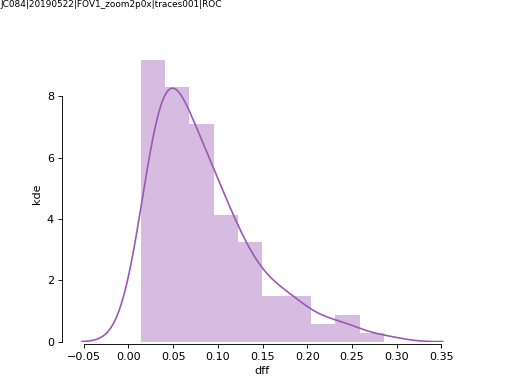

In [11]:
max_dffs_by_config = [estats.gdf.get_group(roi).groupby(['config']).mean()['dff'].max() for roi in roi_list]
fig, ax = pl.subplots()
sns.distplot(max_dffs_by_config, ax=ax)
sns.despine(ax=ax, trim=True, offset=2)
ax.set_xlabel('dff')
ax.set_ylabel('kde')
label_figure(fig, data_identifier)
pl.savefig(os.path.join(summarydir, 'hist-avg-dff-best-cfg.png'))


# Load tuning fits

In [12]:
response_type = 'dff'
n_bootstrap_iters = 100
n_intervals_interp=3
goodness_thr = 0.66
make_plots = True
create_new=False

In [14]:

fitdf, fitparams, fitdata = exp.fit_tuning(response_type=response_type, make_plots=make_plots, plot_metrics=False,
                                           n_bootstrap_iters=n_bootstrap_iters, n_intervals_interp=n_intervals_interp, 
                                           responsive_test=responsive_test, responsive_thr=responsive_thr, 
                                           create_new=create_new)


Fit descriptor: bootstrap-fit-remove-bas_responsive-ROC-thr0.05
Getting tuning for: /n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_55a5cc_traces001_7eef99_traces001_809b80_traces001_fbc03e/tuning/bootstrap-fit-remove-bas_responsive-ROC-thr0.05
Loading existing fits.
... plotting comparison metrics ...
*** done! ***


#### Test fit quality with goodness-of-fit metric

In [15]:
goodness_thr = 0.66
fitdf, gfits = osi.check_fit_quality(fitdf, fitdata)
goodfits = osi.threshold_fitness_quality(gfits, goodness_thr=goodness_thr, plot_hist=False)


/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/bootstrap_fit_tuning_curves.py:1045: RuntimeWarning: invalid value encountered in sqrt
  gfit = np.mean(fitdf_roi['r2']) * (1-iqr) * np.sqrt(r2_comb)


In [16]:
allfits = fitdf['cell'].unique()

# Set output dir to tuning dir

In [17]:
tuningdir = fitparams['directory']
print tuningdir

/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_55a5cc_traces001_7eef99_traces001_809b80_traces001_fbc03e/tuning/bootstrap-fit-remove-bas_responsive-ROC-thr0.05


# Visualize tuning characteristics of well-fit neurons

In [18]:

fit_desc = os.path.split(fitparams['directory'])[-1]
data_identifier = '|'.join([exp.animalid, exp.session, exp.fov, exp.traceid, fit_desc])


In [19]:
df = fitdf[fitdf['cell'].isin(goodfits)]


#### Sort by DSI

In [20]:
def compare_iterations_sortby(df, sort_by='DSI', descending=True):
    if 'theta' in sort_by or 'rad' in sort_by:
        dsi_values = df.groupby(['cell'])['preferred_rad'].apply(spstats.circmean)
    else:
        dsi_values = df.groupby(['cell']).mean()[sort_by]
    if descending:
        dsi_sorted_ixs = np.argsort(dsi_values).values[::-1] #Sort from biggest to smallest
    else:
        dsi_sorted_ixs = np.argsort(dsi_values).values #Sort from smallest to biggest
    rsort_by_dsi = np.array(dsi_values.index.tolist())[dsi_sorted_ixs]

    evens = []
    odds= []
    for roi in rsort_by_dsi:
        #print roi, dsi_values[roi]
    #    best_configs = fitdata['original_data'][roi]['stimulus_configs']
    #    trace_ixs = exp.data.labels[exp.data.labels['config'].isin(best_configs)].index.tolist()
    #    tmat = exp.data.traces[roi][trace_ixs]
    #    rdf = pd.DataFrame(data=tmat.values, index=tmat.index, columns=['traces'])
    #    rdf['trial'] = exp.data.labels['trial'][trace_ixs]
    #    rdf['config'] = exp.data.labels['config'][trace_ixs]
    #    tmat = np.vstack(rdf.groupby(['config', 'trial'])['traces'].apply(np.array).values)
        responses = fitdata['original_data'][roi]['responses']

        evens.append(responses[0::2].mean().values)
        odds.append(responses[1::2].mean().values)

    evens = np.array(evens)
    odds = np.array(odds)


    cmap = 'inferno'
    fig, axes = pl.subplots(1,2, sharex=True, sharey=True)
    cbar_ax = fig.add_axes([.85, .3, .03, .4])
    vmin = min([evens.min(), odds.min()])
    vmax = max([evens.max(), odds.max()])

    sns.heatmap(evens, ax=axes[0], cbar=True, vmin=vmin, vmax=vmax, cbar_ax=cbar_ax, cmap=cmap)
    axes[0].set_title('evens')
    axes[0].set_xticklabels(fitparams['tested_values'], rotation=45)
    axes[0].tick_params(labelsize=8)
    axes[0].set_ylabel('cell')

    sns.heatmap(odds, ax=axes[1], cbar=0, vmin=vmin, vmax=vmax, cbar_ax=None, cmap=cmap)
    axes[1].set_title('odds')
    axes[1].set_xticklabels(fitparams['tested_values'], rotation=45)
    axes[1].tick_params(labelsize=8)

    pl.subplots_adjust(wspace=0.05, right=0.80)

    fig.suptitle('sort by %s' % sort_by)

    return fig

<IPython.core.display.Javascript object>


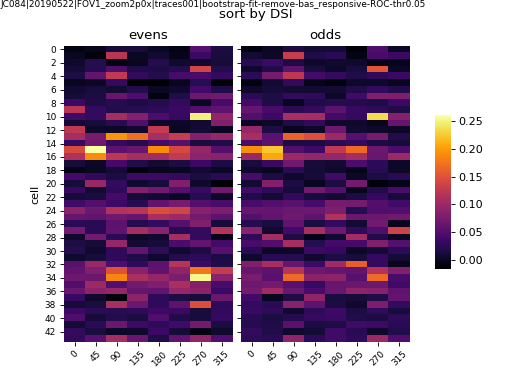

In [21]:
fig = compare_iterations_sortby(df, sort_by='DSI', descending=True)
label_figure(fig, data_identifier)

figname = 'gof%.2f_tuning-on-evens-vs-odd-iters_sort-by-DSI' % goodness_thr
pl.savefig(os.path.join(tuningdir, '%s.png' % figname))

#### Sort by preferred theta

/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


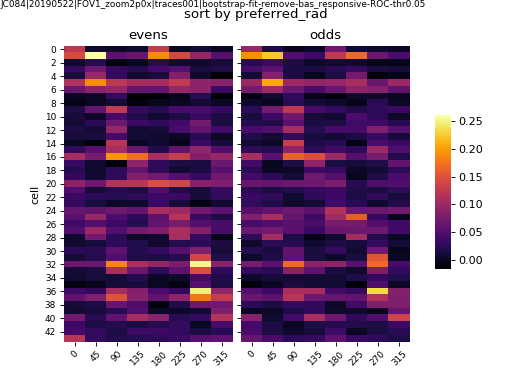

In [22]:
df['preferred_rad'] = np.deg2rad(df['preferred_theta']).values # convert to radians

fig = compare_iterations_sortby(df, sort_by='preferred_rad', descending=False)
label_figure(fig, data_identifier)

figname= 'gof%.2f_tuning-on-evens-vs-odd-iters_sort-by-preferredtheta' % goodness_thr
pl.savefig(os.path.join(tuningdir, '%s.png' % figname))

# Combine bootstrap iters and get profile of each cell

In [23]:
fitdf.head()

,ASI,DSI,cell,preferred_theta,r2,r2comb
0,0.113478,0.241001,1,112.815766,0.816551,0.596873
1,0.164272,0.118872,1,112.198196,0.687734,0.596873
2,0.154520,0.130066,1,91.933135,0.710843,0.596873
3,0.124664,0.158865,1,103.162950,0.815078,0.596873
4,0.140017,0.129466,1,112.218305,0.916464,0.596873


In [28]:
filter_good = True

In [29]:
if filter_good:
    roi_list = copy.copy(goodfits)
    filter_str = 'good-fits-%.2f' % goodness_thr
else:
    roi_list = copy.copy(allfits)
    filter_str = 'all-fits'


tuningdata = []

for roi in roi_list:
    popt = osi.get_average_params_over_iters(fitdata['results_by_iter'][roi])    
    r_pref, r_null, theta_pref, sigma, r_offset = popt
    asi = fitdf[fitdf['cell']==roi]['ASI'].mean()
    dsi = fitdf[fitdf['cell']==roi]['DSI'].mean()
    r2comb = fitdf[fitdf['cell']==roi]['r2comb'].unique()[0]
    tuningdata.append( pd.DataFrame({'ASI': asi,
                                     'DSI': dsi,
                                      'r_pref': r_pref,
                                      'r_null': r_null,
                                      'theta_pref': theta_pref,
                                      'sigma': sigma,
                                      'r_offset': r_offset,
                                    'r2_comb': r2comb}, index=[roi]) )
    
tuning = pd.concat(tuningdata, axis=0)
tuning.head()

,ASI,DSI,r2_comb,r_null,r_offset,r_pref,sigma,theta_pref
5,0.238047,0.239732,0.780260,0.007484,0.013430,0.028899,32.777538,341.510634
9,0.228383,0.035577,0.875168,0.033583,0.019594,0.036970,25.547037,86.912078
12,0.122357,0.043810,0.888324,0.146058,-0.058384,0.149353,62.059412,54.653023
16,0.301303,0.109106,0.955364,0.026630,0.008321,0.031566,34.842009,356.508767
17,0.118398,0.132180,0.941988,0.016785,0.095224,0.097264,23.452496,45.291159


#### Look at distN of each metric

<IPython.core.display.Javascript object>


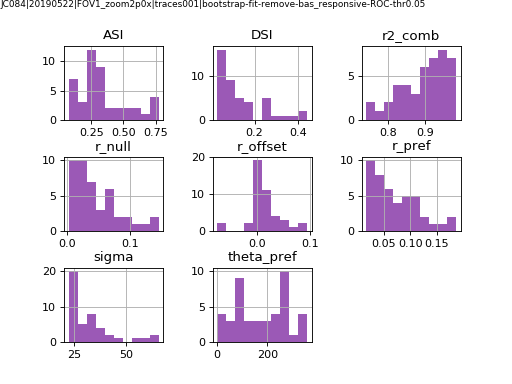

hist-each-metric_good-fits-0.66


In [30]:
fig = tuning.hist()
pl.subplots_adjust(hspace=0.5, wspace=0.5)

label_figure(fig[0][0].figure, data_identifier)

figname = 'hist-each-metric_%s' % filter_str
print(figname)
pl.savefig(os.path.join(tuningdir, '%s.png' % figname))

#### Compare metrics pair-wise

<IPython.core.display.Javascript object>


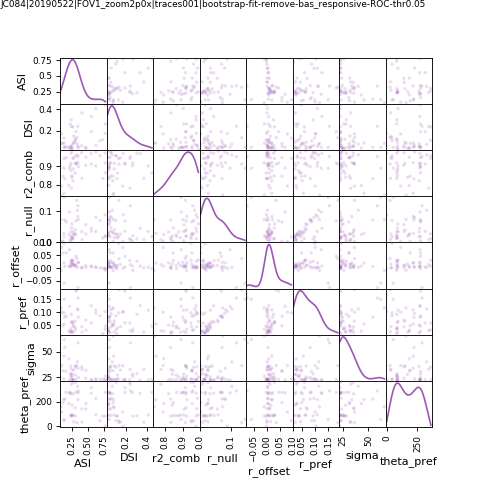

scatter-matrix_good-fits-0.66


In [31]:
from pandas.plotting import scatter_matrix
fig = scatter_matrix(tuning, alpha=0.2, figsize=(6, 6), diagonal='kde')

label_figure(fig[0][0].figure, data_identifier)
figname = 'scatter-matrix_%s' % filter_str
print(figname)
pl.savefig(os.path.join(tuningdir, '%s.png' % figname))

### Find closest matching tested theta to plot histogram of preferred angles

In [35]:
from collections import Counter
from matplotlib import patches

def hist_gratings_stats(tuningdf, all_categories, colorvals, variable='pref_theta', ax=None,
                        thresh=0.33, ori_metric='ASI', show_selective=False):
        
    best_ori_vals = tuningdf[variable]
    best_ori_vals_selective = tuningdf[tuningdf[ori_metric] >= thresh][variable]
    
    ori_counts_all = Counter(best_ori_vals)
    if all_categories is not None:
        for catg in all_categories:
            if catg not in ori_counts_all:
                ori_counts_all[catg] = 0
                
    ori_counts_selective = Counter(best_ori_vals_selective)
    for ori in ori_counts_all.keys():
        if ori not in ori_counts_selective.keys():
            ori_counts_selective[ori] = 0
   
    bar_palette = colorvals.as_hex()
    
    if ax is None:
        fig, ax = pl.subplots()
    
    sns.barplot(sorted(ori_counts_all.keys()), [ori_counts_all[c] for c in sorted(ori_counts_all.keys())], palette=bar_palette, ax=ax)
    ax.tick_params(axis='x', which='both', length=0)

    if show_selective:    
        ax2 = ax.twinx()
        sns.barplot(sorted(ori_counts_all.keys()), [ori_counts_selective[c] for c in sorted(ori_counts_all.keys())], palette=bar_palette, ax=ax2)
        ax2.set_ylim(ax.get_ylim())
        hatch = '//' #itertools.cycle(['/', '//', '+', '-', 'x', '\\', '*', 'o', 'O', '.'])
        for i, bar in enumerate(ax2.patches):
            bar.set_hatch(hatch)
        ax2.set_yticklabels([])
        ax2.tick_params(axis='both', which='both', length=0)
    
        hatch1 = patches.Patch( facecolor='white', hatch=r'\\\\',label='%s > %.2f' % (ori_metric, thresh))
        ax2.legend(handles = [hatch1], loc=1)
        
    sns.despine(trim=True, offset=4)
        
    return ax

In [32]:
tested_thetas = fitparams['tested_values']
tested_thetas.append(360)

tested_thetas = np.array(tested_thetas)

tuning['theta_tested'] = [tested_thetas[np.where(np.abs(t-tested_thetas) == np.min(np.abs(t-tested_thetas)))[0][0]] % 360 for t in tuning['theta_pref']]
tested_thetas = tested_thetas[0:-1]

In [33]:
tuning.head()

,ASI,DSI,r2_comb,r_null,r_offset,r_pref,sigma,theta_pref,theta_tested
5,0.238047,0.239732,0.780260,0.007484,0.013430,0.028899,32.777538,341.510634,0
9,0.228383,0.035577,0.875168,0.033583,0.019594,0.036970,25.547037,86.912078,90
12,0.122357,0.043810,0.888324,0.146058,-0.058384,0.149353,62.059412,54.653023,45
16,0.301303,0.109106,0.955364,0.026630,0.008321,0.031566,34.842009,356.508767,0
17,0.118398,0.132180,0.941988,0.016785,0.095224,0.097264,23.452496,45.291159,45


<IPython.core.display.Javascript object>


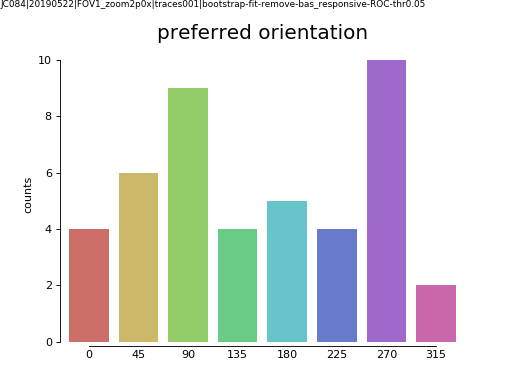

hist-tested-oris_good-fits-0.66


In [36]:
cmap = 'hls'
noris = len(tested_thetas)

fig, ax = pl.subplots()
colorvals = sns.color_palette(cmap, noris) # len(gratings_sconfigs))
show_selective = False if filter_good else True
if tested_thetas.shape[0] > 0:
    hist_gratings_stats(tuning, tested_thetas, colorvals, ax=ax, variable='theta_tested',
                       thresh=goodness_thr, ori_metric='r2_comb', show_selective=show_selective)
ax.set_title('preferred orientation', fontsize=18)
ax.set_ylabel('counts')
        
    
    
label_figure(fig, data_identifier)
figname = 'hist-tested-oris_%s' % filter_str
print(figname)
pl.savefig(os.path.join(tuningdir, '%s.png' % figname))
